## Clasificacion

### Teoria

Dataset $\{(x_i,y_i)\}$:

x | y | cidificacion one-hot
- | - | -
(0,0) | $\triangle$ |[1,0]
(1,0) | $\triangle$ |[1,0]
(1,1) | $\circ$ |[0,1]
(0,1) | $\circ$ |[0,1]

Cada $y_i$ se describen como datos distribuidos por Bernoulli, equivalentemente:

$$\operatorname{P}(y_i=y\mid x_i)=p^y(1-p)^{(1-y)},\quad y=0,1$$

Con esta distribucion el resultado de la red neuronal $\hat{y}=\operatorname{\mathbb{E}}[y_i\mid x_i]=p$. Se optimisa con funcion de perdida
$$\log\operatorname{P}(y\mid x)= y\log\hat{y}+(1-y)\log(1-\hat{y})=-L(\hat{y},y)$$
Maximizar la probabilidad es minimizar $L$.

La funcion de costo $J$, se obtiene de
$$\log∏\Pr(y_i=y\mid x_i)=\log∑\Pr(y_i=y\mid x_i)=-∑L(\hat{y}_i,y_i),$$
$$J(w,b)=1/m∑L(\hat{y}_i,y_i).$$



Modelo neuronal

con las funciones de activacion en cada capa $\sigma(z)=\mathrm{tanh}z$ y funcion logistica $\sigma(z)=\frac {1}{1+e^{-z}}$.

Modelo neuronal, clasificacion binaria
$$x \;\;\xrightarrow{\qquad}\;\; z_1=w_1x+b_1\;\; |\;\; a_1=\sigma(z_1)\;\;\xrightarrow{\qquad}\;\;  z_2=w_2a_1+b_2\;\; |\;\; a_2=\sigma(z_2)\;\;\xrightarrow{\qquad}\;\; L(a,y)$$

Activacion, softmax y tanh
$$a_1=\mathrm{tanh}z_1,\quad a_2=\mathrm{softmax}(z_2).$$

Funcion perdida y costo
$$\begin{aligned}
L(a_2,y) &= -y\log a_2-(1-y)\log(1-a_2)\\
J(w,b)&=1/m∑L(\hat{y}_i,y_i)\\
J(w,b)&+=\frac{λ}{2m}\sum_i^L||w^{[i]}||^2_F\qquad\text{con regulacion}
\end{aligned}$$

Backpropagation
$$\begin{aligned}
\frac{∂J}{∂z_2} & = \frac{∂J}{∂a_2}\frac{∂a_2}{∂z_2} = (\frac{-y}{a_2}+\frac{1-y}{1-a_2})(a_2(1-a_2)) = a_2-y\\
\frac{∂J}{∂w_2} & = \frac{∂J}{∂z_2}\frac{∂z_2}{∂w_2} = \frac{∂J}{∂z_2}a_1\\
\frac{∂J}{∂b_2} & = \frac{∂J}{∂z_2}\frac{∂z_2}{∂b_2} = \frac{∂J}{∂z_2}\\
\frac{∂J}{∂z_1} & = \frac{∂J}{∂z_2}\frac{∂z_2}{∂a_1}\frac{∂a_1}{∂z_1} =  \frac{∂J}{∂z_2}w_2(1-a_1^2)\\
\frac{∂J}{∂w_1} & = \frac{∂J}{∂z_1}x\\
\frac{∂J}{∂b_1} & = \frac{∂J}{∂z_1}
\end{aligned}$$

 $e_i := \frac{∂J}{∂a_i},\,\delta_i := \frac{∂J}{∂z_i}$ y $du:=\frac{∂J}{∂u}$ (esta ultima aunque esta mal, asi se encuentra en la literatura).

Actualizacion de parametros con regularizacion

$$\begin{aligned}
dw & = dw+λw\quad\text{regularization}\\
w & =  w - \epsilon dw\quad\,\text{update}\\
b & =  b - \epsilon db\qquad\text{update}
\end{aligned}$$

### Practica I

In [1]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
#from sklearn.linear_model import LinearRegressionCV
from sklearn.inspection import DecisionBoundaryDisplay
from itertools import product

print('\U0001F44C')

👌


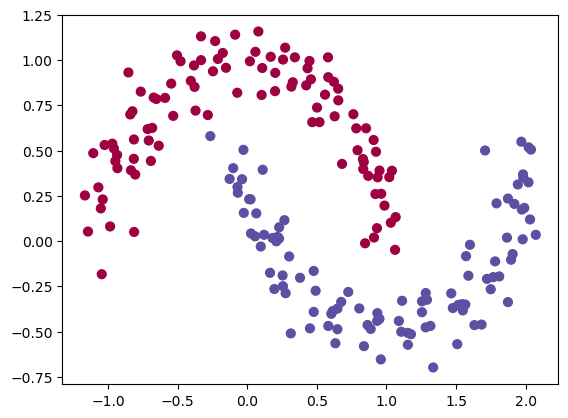

In [2]:
#@title DataSet
np.random.seed(0)
X, Y = make_moons(200, noise=0.10)
plt.scatter(X[:,0], X[:,1], s=40, c=Y, cmap=plt.cm.Spectral)

In [4]:
#@title Build Model

from itertools import zip_longest

def Forward_propagation(x, b, w):
  a = list(range(len(w)))
  z0 = x.dot(w[0]) + b[0]
  a[0] = np.tanh(z0)
  z1 = a[0].dot(w[1]) + b[1]
  a[1] = np.exp(z1) / np.sum(np.exp(z1), axis=1, keepdims=True)
  return a

def Backpropagation(x, y, w, a):
  db, dw = list(range(len(w))), list(range(len(w)))
  m=len(x)
  delta2 = a[1]
  delta2[range(m), y] -= 1
  dw[1] = (a[0].T).dot(delta2)
  db[1] = np.sum(delta2, axis=0, keepdims=True)
  delta1 = delta2.dot(w[1].T)*(1-np.square(a[0]))
  dw[0] = np.dot(x.T, delta1)
  db[0] = np.sum(delta1, axis=0)
  return db, dw # Opscional dividir entre m

def calculate_loss(model):
    x, y, b, w, reg_lambda = model['x'], model['y'], model['b'], model['w'], model['reg_lambda']
    a = Forward_propagation(x, b, w)
    L = -np.log(a[-1][range(len(x)), y]) # -log(P[a2_i=y_i])
    J = np.sum(L)
    J += (reg_lambda/2)*sum([np.sum(np.square(i)) for i in w])
    return 1./len(x)*J

'''
Modelo con mini-batch. Mini-batch
* size=len(dataset) se llama batch
*size=1 se llama stochastic
'''
def build_model(x, y, nn=[3,2], epoc=20000, reg_lambda=0.01, epsilon=0.01, print_loss=False, mini_batch=0, momentum=0):
  nn.insert(0, x.shape[1])
  model = {'x' : x, 'y' : y, 'nn' : nn, 'reg_lambda' : reg_lambda, 'mini_batch' : mini_batch, 'momentum' : momentum}
  if mini_batch==0 or mini_batch==len(x): pass
  elif mini_batch>len(x): return print('mini-batch mayor al data set')
  elif mini_batch<0: return print('mini-batch no valido')
  else:
    x_lang, y_lang = x, y
    while len(x_lang) <  mini_batch*epoc:
      x_lang = np.concatenate((x, x_lang), axis=0)
      y_lang = np.concatenate((y, y_lang), axis=0)

  vdw,vdb,w,b=[],[],[],[]
  for i in range(len(nn)-1):
    vdw.append(np.zeros((nn[i], nn[i+1])))
    vdb.append(np.zeros((1, nn[i+1])))
    w.append(np.random.randn(nn[i], nn[i+1])/np.sqrt(nn[i]))
    b.append(np.zeros((1, nn[i+1])))

  for i in range(0, epoc):   # decenso de gradiente
    if mini_batch==0 or mini_batch==len(x): pass
    else:
      x = x_lang[i*mini_batch:(i+1)*mini_batch]
      y = y_lang[i*mini_batch:(i+1)*mini_batch]
    a = Forward_propagation(x, b, w)
    db, dw = Backpropagation(x, y, w, a)
    vdw = [sum(n) for n in zip_longest([momentum*i for i in vdw], [(1-momentum)*i for i in dw], fillvalue=0)]
    vdb = [sum(n) for n in zip_longest([momentum*i for i in vdb], [(1-momentum)*i for i in db], fillvalue=0)]
    vdw= [sum(n) for n in zip_longest(vdw, [reg_lambda * i for i in w], fillvalue=0)]
    w = [sum(n) for n in zip_longest(w, [-epsilon * i for i in vdw], fillvalue=0)]
    b = [sum(n) for n in zip_longest(b, [-epsilon * i for i in vdb], fillvalue=0)]
    model.update({'b': b, 'w': w})
    if print_loss and i % 1000 == 0:
      print('Loss after iteration %i: %f' %(i, calculate_loss(model)))

  return model

def predict(model, z):
    a = Forward_propagation(z, model['b'], model['w'])
    return np.argmax(a[-1], axis=1)

def plot_decision_boundary(model):
  x, y, nn, mini_batch, momentum = model['x'], model['y'], model['nn'], model['mini_batch'], model['momentum']
  x_1, x_2 = np.meshgrid(np.linspace(x[:, 0].min(), x[:, 0].max()), np.linspace(x[:, 1].min(), x[:, 1].max()))
  grid = np.vstack([x_1.ravel(), x_2.ravel()]).T
  y_pred = np.reshape(predict(model, grid), x_1.shape)

  display = DecisionBoundaryDisplay(xx0=x_1, xx1=x_2, response=y_pred)
  display.plot()
  display.ax_.scatter(x[:,0], x[:,1], s=40, c=y, cmap=plt.cm.Spectral)
  plt.title('Modelo: %d neurons, mini-batch size %d, momentum = %.2f' %(nn[1], mini_batch, momentum))
  plt.show()

'''
Modelo sin mini_batch, momentum
'''
def model(x, y, nn=[3,2], epoc=20000, reg_lambda=0.01, epsilon=0.01, print_loss=False):
  nn.insert(0, x.shape[1])
  print(nn)
  model = {'x' : x, 'y' : y, 'nn' : nn, 'reg_lambda' : reg_lambda}
  w,b=[],[]
  np.random.seed(0)
  for i in range(len(nn)-1):
    w.append(np.random.randn(nn[i], nn[i+1])/np.sqrt(nn[i]))
    b.append(np.zeros((1, nn[i+1])))

  for i in range(0, epoc):   # Gradient descent. For each epoc...
    a = Forward_propagation(x, b, w)
    db, dw = Backpropagation(x, y, w, a)
    dw= [sum(n) for n in zip_longest(dw, [reg_lambda * i for i in w], fillvalue=0)] # Regularizacion
    w = [sum(n) for n in zip_longest(w, [-epsilon * i for i in dw], fillvalue=0)]    # Actualizacion
    b = [sum(n) for n in zip_longest(b, [-epsilon * i for i in db], fillvalue=0)]    # Actualizacion
    model.update({'b': b, 'w': w})
    if print_loss and i % 1000 == 0:
      print('Loss after iteration %i: %.2f' %(i, calculate_loss(model)))

  return model

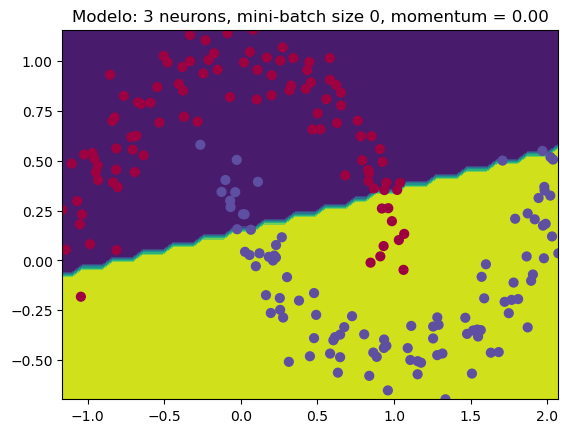

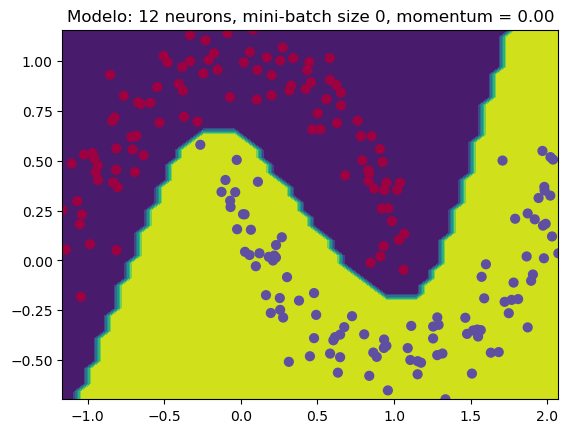

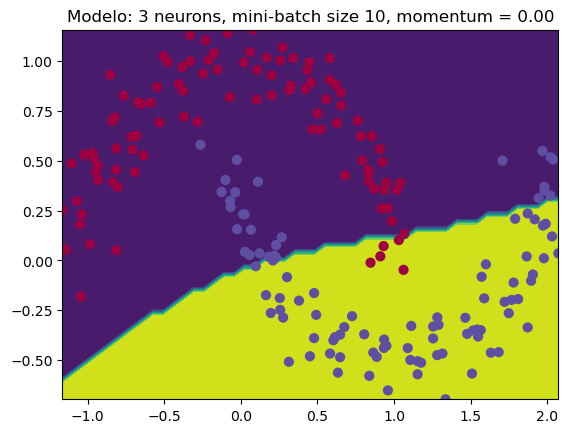

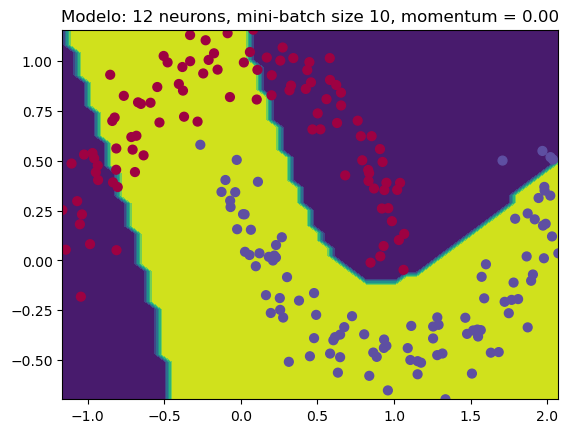

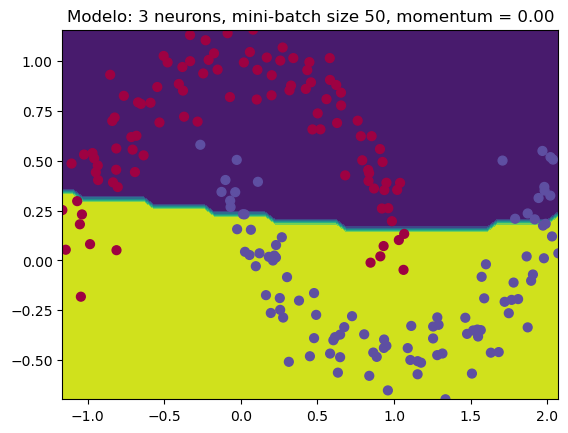

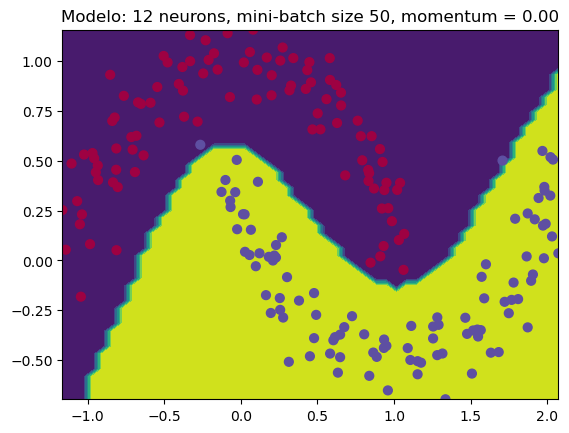

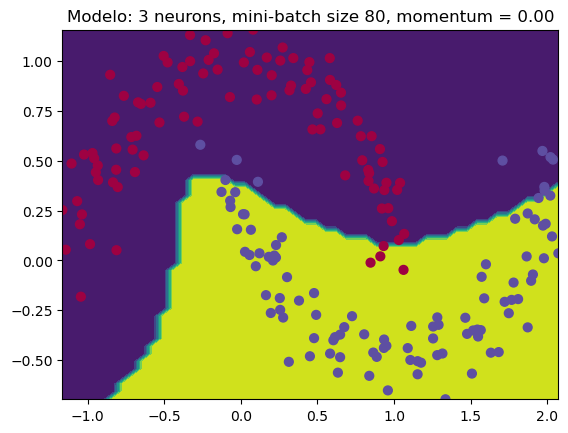

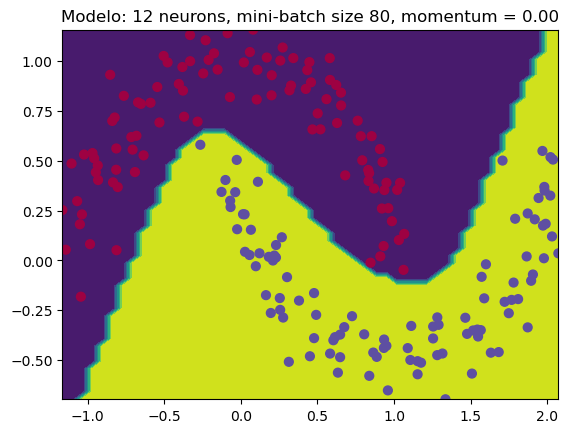

In [7]:
#@title Run

mini_batch = [0, 10, 50, 80]
for subset in mini_batch:
    model = build_model(X, Y, nn=[3, 2], epoc=200, mini_batch=subset, print_loss=False)
    model2 = build_model(X, Y, nn=[12, 2], mini_batch=subset, print_loss=False)
    plot_decision_boundary(model), plot_decision_boundary(model2)

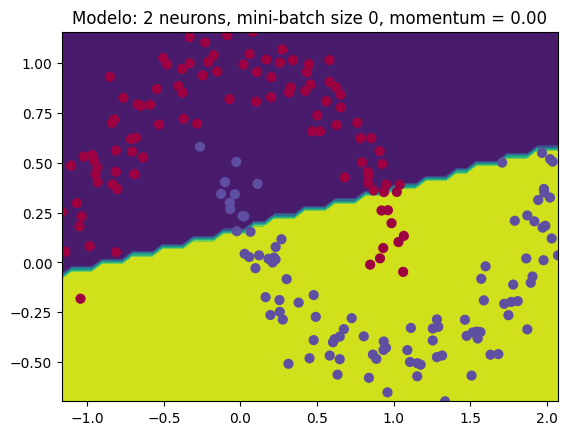

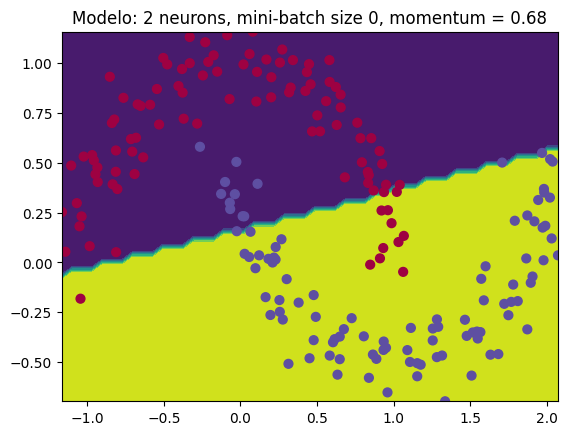

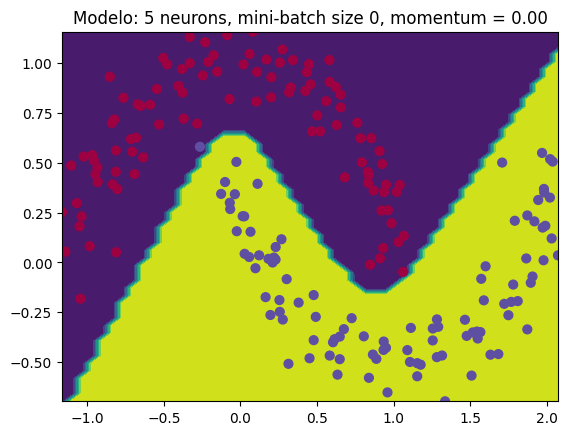

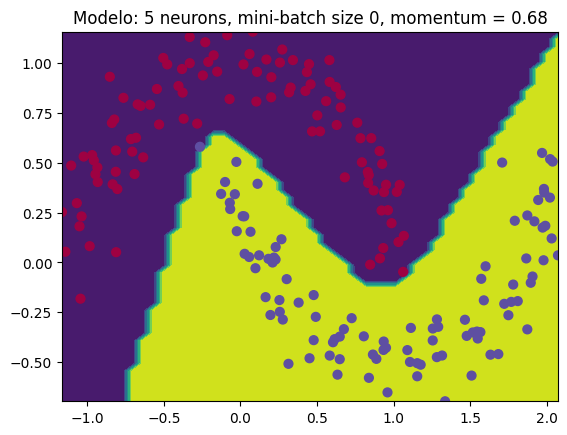

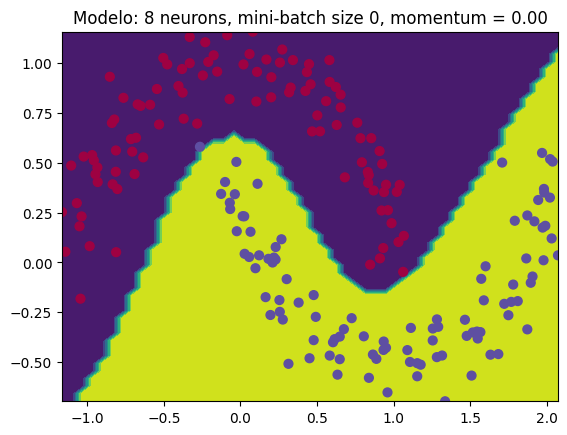

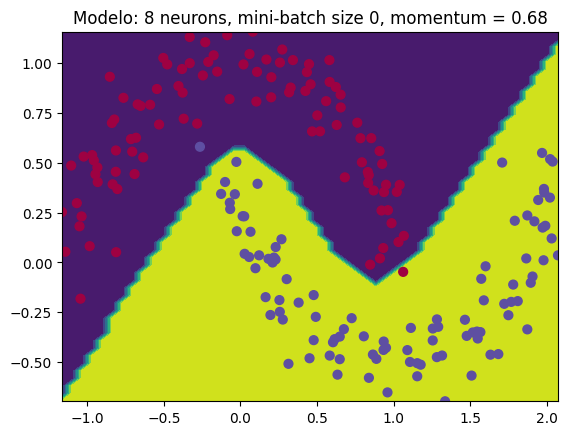

In [ ]:
#@title Run

for i in range(3):
  model1 = build_model(X, Y, nn=[2+3*i, 2], epoc=150, print_loss=False)
  model2 = build_model(X, Y, nn=[2+3*i, 2], epoc=150, print_loss=False, momentum=0.68)
  plot_decision_boundary(model1), plot_decision_boundary(model2)

20 neurons good, 50 neurons overfit